In [ ]:
import numpy as np
import math
import helper_functions as hf
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from name_list import *
from numba import jit, objmode, threading_layer, config, prange
import psutil


config.THREADING_LAYER = 'omp'

@jit(nopython=True, parallel=True)
def run_sim(u1, u2, v1, v2, h1, h2):
    locs = hf.genlocs(num, N, 0) ### use genlocs instead of paircount
    mode = 1

    wlayer = hf.pairshapeN2(locs, 0) ### use pairshapeBEGIN instead of pairshape
    Wmat = hf.pairfieldN2(L, h1, wlayer)

    # TIME STEPPING
    if AB == 2:
        u1_p = u1.copy()
        v1_p = v1.copy()
        h1_p = h1.copy()
        u2_p = u2.copy()
        v2_p = v2.copy()
        h2_p = h2.copy()

    ts = []
    psi2 = np.zeros_like(x)
    zeta1 = psi2.copy()
    zeta2 = psi2.copy()
    B2 = psi2.copy()
    B1p = B2.copy()

    ii = 0
    zeta2mat = []
    h2mat = []
    u2mat = []

    Wpulse = []

    KEmat = []
    APEmat = []

    with objmode(timer='f8'):
        timer = time.perf_counter()

    tpulseper = tstpf
    tpulsedur = tstf
    tclock = 0
    t = 0
    tc = 0

    while t <= tmax + dt / 2:

        if AB == 2:
            tmp = u1.copy()
            u1 = 1.5 * u1 - 0.5 * u1_p
            u1_p = tmp  #
            tmp = u2.copy()
            u2 = 1.5 * u2 - 0.5 * u2_p
            u2_p = tmp  #
            tmp = v1.copy()
            v1 = 1.5 * v1 - 0.5 * v1_p
            v1_p = tmp
            tmp = v2.copy()
            v2 = 1.5 * v2 - 0.5 * v2_p
            v2_p = tmp
            tmp = h1.copy()
            h1 = 1.5 * h1 - 0.5 * h1_p
            h1_p = tmp
            if layers == 2.5:
                tmp = h2.copy()
                h2 = 1.5 * h2 - 0.5 * h2_p
                h2_p = tmp

        # add friction
        du1dt = hf.viscND(u1, Re, n)
        du2dt = hf.viscND(u2, Re, n)
        dv1dt = hf.viscND(v1, Re, n)
        dv2dt = hf.viscND(v2, Re, n)

        if spongedrag1 > 0:
            du1dt = du1dt - spdrag1 * (u1)
            du2dt = du2dt - spdrag2 * (u2)
            dv1dt = dv1dt - spdrag1 * (v1)
            dv2dt = dv2dt - spdrag2 * (v2)

        # absolute vorticity
        zeta1 = 1 - Bt * rdist**2 + (1 / dx) * (v1 - v1[:,l] + u1[l,:] - u1)
        
        zeta2 = 1 - Bt * rdist**2 + (1 / dx) * (v2 - v2[:,l] + u2[l,:] - u2)


        # add vorticity flux, zeta*u
        zv1 = zeta1 * (v1 + v1[:,l])
        zv2 = zeta2 * (v2 + v2[:,l])

        du1dt = du1dt + 0.25 * (zv1 + zv1[r,:])
        du2dt = du2dt + 0.25 * (zv2 + zv2[r,:])

        zu1 = zeta1 * (u1 + u1[l,:])
        zu2 = zeta2 * (u2 + u2[l,:])

        dv1dt = dv1dt - 0.25 * (zu1 + zu1[:,r])
        dv2dt = dv2dt - 0.25 * (zu2 + zu2[:,r])

        ### Cumulus Drag (D) ###
        du1dt = du1dt - (1 / dx) * u1 / dragf
        du2dt = du2dt - (1 / dx) * u2 / dragf
        dv1dt = dv1dt - (1 / dx) * v1 / dragf
        dv2dt = dv2dt - (1 / dx) * v2 / dragf

        B1p, B2p = hf.BernN2(u1, v1, u2, v2, gm, c22h, c12h, h1, h2, ord)

        du1dtsq = du1dt - (1 / dx) * (B1p - B1p[:,l])
        du2dtsq = du2dt - (1 / dx) * (B2p - B2p[:,l])

        dv1dtsq = dv1dt - (1 / dx) * (B1p - B1p[l,:])
        dv2dtsq = dv2dt - (1 / dx) * (B2p - B2p[l,:])

        if AB == 2:
            u1sq = u1_p + dt * du1dtsq
            u2sq = u2_p + dt * du2dtsq

            v1sq = v1_p + dt * dv1dtsq
            v2sq = v2_p + dt * dv2dtsq

        ##### new storm forcing -P #####

        remove_layers = [] # store weather layers that need to be removed here

        if mode == 1:
            for i in range(len(locs)):
                if (t-locs[i][-1]) >= locs[i][3] and t != 0:
                    remove_layers.append(i) # tag layer for removal if a storm's 

            add = len(remove_layers) # number of storms that were removed

            if add != 0:
                newlocs = hf.genlocs(add, N, t)

                for i in range(len(remove_layers)):
                    locs[remove_layers[i]] = newlocs[i]

                wlayer = hf.pairshapeN2(locs, t) ### use pairshapeBEGIN instead of pairshape
                Wmat = hf.pairfieldN2(L, h1, wlayer)

        ##### new storm forcing -P #####

        Fx1 = hf.xflux(h1, u1) - kappa / dx * (h1 - h1[:,l])
        Fy1 = hf.yflux(h1, v1) - kappa / dx * (h1 - h1[l,:])
        dh1dt = -(1 / dx) * (Fx1[:,r] - Fx1 + Fy1[r,:] - Fy1)

        if layers == 2.5:
            Fx2 = hf.xflux(h2, u2) - kappa / dx * (h2 - h2[:,l])
            Fy2 = hf.yflux(h2, v2) - kappa / dx * (h2 - h2[l,:])

            dh2dt = -(1 / dx) * (Fx2[:,r] - Fx2 + Fy2[r,:] - Fy2)

        if tradf > 0:
            dh1dt = dh1dt - 1 / tradf * (h1 - 1)
            dh2dt = dh2dt - 1 / tradf * (h2 - 1)

        if mode == 1:
            dh1dt = dh1dt + Wmat.astype(np.float64)
            if layers == 2.5:
                dh2dt = dh2dt - H1H2 * Wmat.astype(np.float64)

        if AB == 2:
            h1 = h1_p + dt * dh1dt
            if layers == 2.5:
                h2 = h2_p + dt * dh2dt

        u1 = u1sq
        u2 = u2sq
        v1 = v1sq
        v2 = v2sq

        if tc % tpl == 0:
            with objmode(timer='f8'):
                print(f"t={t}, mean h1 is {round(np.mean(np.mean(h1)), 4)}, num storms {locs.shape[0]}. Time elapsed, {round(time.perf_counter()-timer, 3)}s. CPU usage, {psutil.cpu_percent()}")
                timer = time.perf_counter()

            ii += 1
        
            ts.append(t)

            u2mat.append(u2)
            h2mat.append(h2)
            zeta2mat.append(zeta2)

            Wpulse.append(Wmat)

            KEmat.append(hf.calculate_KE(u1,u2,v1,v2,h1,h2))
            APEmat.append(hf.calculate_APE(h1, h2))
                
        if math.isnan(h1[0, 0]):
            print("NAN h1")
            break

        tc += 1
        t = tc * dt

    return u2mat, h2mat, zeta2mat, KEmat, APEmat, Wpulse

u2mat, h2mat, zeta2mat, KEmat, APEmat, Wpulse = run_sim(u1,u2,v1,v2,h1,h2)


print("Threading layer chosen: %s" % threading_layer())
print("Num Threads: %s" % config.NUMBA_NUM_THREADS)


In [ ]:
from IPython.display import HTML


plt.rc('animation', html='html5')


plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  

In [ ]:
### Saving ###
PV2 = zeta2mat - (1 - Bt*rdist**2)

#print(PV2.shape)
#np.save(f"Run_{round(time.time())}", [u2mat,h2mat,PV2])

frames = PV2

fmin = np.min(frames)
fmax = np.max(frames)

fig = plt.figure()
ax = fig.add_subplot(111)

cv0 = frames[0]
im = ax.imshow(cv0, cmap="bwr")
cb = fig.colorbar(im)
tx = ax.set_title(f"time: {0}")


def animate(i):
    arr = frames[i]

    vmax = np.max(arr)
    vmin = np.min(arr)
    im.set_data(arr)
    im.set_clim(fmin, fmax)
    tx.set_text(f"time: {i}")


ani = animation.FuncAnimation(fig, animate, interval=ani_interval, frames=len(frames))
HTML(ani.to_html5_video())

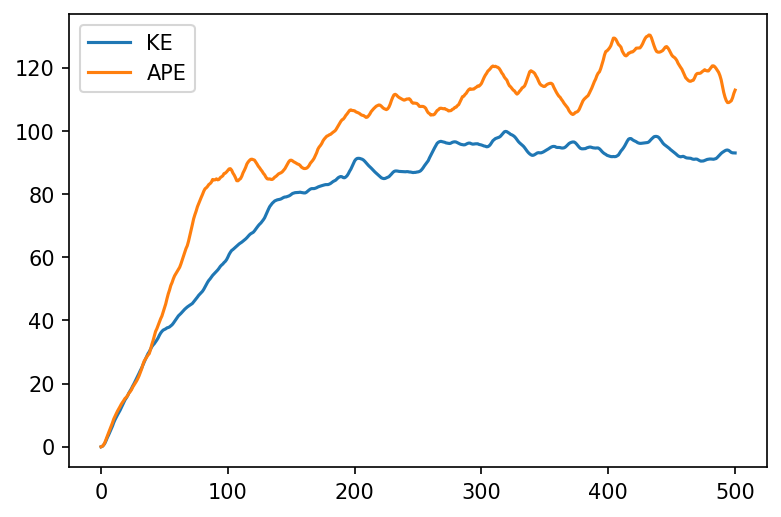

In [7]:
plt.plot(KEmat, label="KE")
plt.plot(APEmat, label="APE")
plt.legend(frameon=True)